## CCS prediction - Training, validating and testing a ML regression model and classifier

**Author:** Quentin Duez

This notebook parses and processes molecular descriptors from DFT calculations. The descriptors are used in conjuction with collisional cross sections (CCS) determined experimentally on host-guest complexes to train a ML regression model. The model is validated through cross-validation strategies, and tested to predict the CCS and topology of host-guest complexes previously unseen.

**Outputs:** Figures 3, 4, Figures S15-20.

**Disclaimer :**
Parts of this notebook correspond to code available on the auto-qchem GitHub repository 

Please refer to the [original repository](https://github.com/doyle-lab-ucla/auto-qchem/) and [related publication](https://pubs.rsc.org/en/content/articlelanding/2022/re/d2re00030j#!divCitation)

In [1]:
import ast
import heapq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.linalg import qr  # qr decomposition
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, silhouette_score
from sklearn.model_selection import (KFold, RepeatedKFold, cross_val_predict,
                                     cross_val_score, cross_validate)
from sklearn.preprocessing import scale
from umap import UMAP

In [2]:
# Read global data
global_data = pd.read_excel("global_data.xlsx", index_col=0)
global_data = global_data.drop(columns=["inchi", "inchi_key", "index", "stoichiometry"])

# Read atomic data, and add data for each N atom
atom_df = pd.read_excel("atom_data.xlsx")
atom_df = atom_df.drop(
    columns=["Unnamed: 0", "inchi", "inchi_key", "index", "X", "Y", "Z"]
)

# Parsing for the diamines
# We want to get all the atomic parameters for the Ns
total_N_df = pd.DataFrame()
for index, row in atom_df.iterrows():
    element_list = row["elements"]
    element_list = ast.literal_eval(element_list)  # convert the str to a list
    conn_matrix = row["connectivity_matrix"]
    conn_matrix = ast.literal_eval(conn_matrix)  # convert the str to a list

    VBur = row["VBur"]
    VBur = ast.literal_eval(VBur)  # convert the str to a list
    Mulliken_charges = row["Mulliken_charge"]
    Mulliken_charges = ast.literal_eval(Mulliken_charges)  # convert the str to a list
    APT_charges = row["APT_charge"]
    APT_charges = ast.literal_eval(APT_charges)  # convert the str to a list
    NPA_charges = row["NPA_charge"]
    NPA_charges = ast.literal_eval(NPA_charges)  # convert the str to a list
    NPA_valence = row["NPA_valence"]
    NPA_valence = ast.literal_eval(NPA_valence)  # convert the str to a list
    NPA_Rydberg = row["NPA_Rydberg"]
    NPA_Rydberg = ast.literal_eval(NPA_Rydberg)  # convert the str to a list
    NMR_shift = row["NMR_shift"]
    NMR_shift = ast.literal_eval(NMR_shift)  # convert the str to a list
    NMR_anisotropy = row["NMR_anisotropy"]
    NMR_anisotropy = ast.literal_eval(NMR_anisotropy)  # convert the str to a list

    # get indices for the N atoms
    indices_N = [i for i, x in enumerate(element_list) if x == "N"]
    # print(row["can"])

    # Manually find indices of the terminal amines for compounds with more than 2 Ns
    if row["can"] == "NC1=CC=C([N+]([O-])=O)C=C1N":
        indices_N = [0, 10]
    elif row["can"] == "NC1=CC=C(/N=N/C2=CC=C(N)C=C2)C=C1":
        indices_N = [0, 11]
    elif row["can"] == "O=C(NC1=CC=C(N)C=C1)C2=CC=C(N)C=C2":
        indices_N = [7, 14]
    else:
        indices_N = indices_N

    # get indices for the atoms connected to Ns, taking into account -N= (for NO2)
    atoms_N1 = [
        j
        for j, y in enumerate(
            conn_matrix[
                indices_N[0]
                * len(element_list) : (indices_N[0] + 1)
                * len(element_list)
            ]
        )
        if y == 1 or y == 2
    ]
    atoms_N2 = [
        k
        for k, z in enumerate(
            conn_matrix[
                indices_N[1]
                * len(element_list) : (indices_N[1] + 1)
                * len(element_list)
            ]
        )
        if z == 1 or z == 2
    ]

    # get parameters for N1 and N2, and all three atoms connected to the N
    N_dict = {
        "N1_VBur": VBur[indices_N[0]],
        "N1_Mulliken_charge": Mulliken_charges[indices_N[0]],
        "N1_APT_charge": APT_charges[indices_N[0]],
        "N1_NPA_charge": NPA_charges[indices_N[0]],
        "N1_NPA_valence": NPA_valence[indices_N[0]],
        "N1_NPA_Rydberg": NPA_Rydberg[indices_N[0]],
        "N1_NMR_shift": NMR_shift[indices_N[0]],
        "N1_NMR_anisotropy": NMR_anisotropy[indices_N[0]],
        "N2_VBur": VBur[indices_N[1]],
        "N2_Mulliken_charge": Mulliken_charges[indices_N[1]],
        "N2_APT_charge": APT_charges[indices_N[1]],
        "N2_NPA_charge": NPA_charges[indices_N[1]],
        "N2_NPA_valence": NPA_valence[indices_N[1]],
        "N2_NPA_Rydberg": NPA_Rydberg[indices_N[1]],
        "N2_NMR_shift": NMR_shift[indices_N[1]],
        "N2_NMR_anisotropy": NMR_anisotropy[indices_N[1]],
        "A11_VBur": VBur[atoms_N1[0]],
        "A11_Mulliken_charge": Mulliken_charges[atoms_N1[0]],
        "A11_APT_charge": APT_charges[atoms_N1[0]],
        "A11_NPA_charge": NPA_charges[atoms_N1[0]],
        "A11_NPA_valence": NPA_valence[atoms_N1[0]],
        "A11_NPA_Rydberg": NPA_Rydberg[atoms_N1[0]],
        "A11_NMR_shift": NMR_shift[atoms_N1[0]],
        "A11_NMR_anisotropy": NMR_anisotropy[atoms_N1[0]],
        "A12_VBur": VBur[atoms_N1[1]],
        "A12_Mulliken_charge": Mulliken_charges[atoms_N1[1]],
        "A12_APT_charge": APT_charges[atoms_N1[1]],
        "A12_NPA_charge": NPA_charges[atoms_N1[1]],
        "A12_NPA_valence": NPA_valence[atoms_N1[1]],
        "A12_NPA_Rydberg": NPA_Rydberg[atoms_N1[1]],
        "A12_NMR_shift": NMR_shift[atoms_N1[1]],
        "A12_NMR_anisotropy": NMR_anisotropy[atoms_N1[1]],
        "A13_VBur": VBur[atoms_N1[2]],
        "A13_Mulliken_charge": Mulliken_charges[atoms_N1[2]],
        "A13_APT_charge": APT_charges[atoms_N1[2]],
        "A13_NPA_charge": NPA_charges[atoms_N1[2]],
        "A13_NPA_valence": NPA_valence[atoms_N1[2]],
        "A13_NPA_Rydberg": NPA_Rydberg[atoms_N1[2]],
        "A13_NMR_shift": NMR_shift[atoms_N1[2]],
        "A13_NMR_anisotropy": NMR_anisotropy[atoms_N1[2]],
        "A21_VBur": VBur[atoms_N2[0]],
        "A21_Mulliken_charge": Mulliken_charges[atoms_N2[0]],
        "A21_APT_charge": APT_charges[atoms_N2[0]],
        "A21_NPA_charge": NPA_charges[atoms_N2[0]],
        "A21_NPA_valence": NPA_valence[atoms_N2[0]],
        "A21_NPA_Rydberg": NPA_Rydberg[atoms_N2[0]],
        "A21_NMR_shift": NMR_shift[atoms_N2[0]],
        "A21_NMR_anisotropy": NMR_anisotropy[atoms_N2[0]],
        "A22_VBur": VBur[atoms_N2[1]],
        "A22_Mulliken_charge": Mulliken_charges[atoms_N2[1]],
        "A22_APT_charge": APT_charges[atoms_N2[1]],
        "A22_NPA_charge": NPA_charges[atoms_N2[1]],
        "A22_NPA_valence": NPA_valence[atoms_N2[1]],
        "A22_NPA_Rydberg": NPA_Rydberg[atoms_N2[1]],
        "A22_NMR_shift": NMR_shift[atoms_N2[1]],
        "A22_NMR_anisotropy": NMR_anisotropy[atoms_N2[1]],
        "A23_VBur": VBur[atoms_N2[2]],
        "A23_Mulliken_charge": Mulliken_charges[atoms_N2[2]],
        "A23_APT_charge": APT_charges[atoms_N2[2]],
        "A23_NPA_charge": NPA_charges[atoms_N2[2]],
        "A23_NPA_valence": NPA_valence[atoms_N2[2]],
        "A23_NPA_Rydberg": NPA_Rydberg[atoms_N2[2]],
        "A23_NMR_shift": NMR_shift[atoms_N2[2]],
        "A23_NMR_anisotropy": NMR_anisotropy[atoms_N2[2]],
    }

    N_df = pd.DataFrame(N_dict, index=[index])
    for cols in N_df.columns:
        N_df[cols] = pd.to_numeric(N_df[cols])

    # Average for the values of the three atoms linked to each N
    # COMMENT THE WHOLE BLOCK AND THE DROP COMMAND IF YOU WANT TO KEEP THE INDIVIDUAL VALUES
    N_df["N_VBur_avg"] = N_df[["N1_VBur", "N2_VBur"]].mean(axis=1)
    N_df["N_Mulliken_charge_avg"] = N_df[
        ["N1_Mulliken_charge", "N2_Mulliken_charge"]
    ].mean(axis=1)
    N_df["N_APT_charge_avg"] = N_df[["N1_APT_charge", "N2_APT_charge"]].mean(axis=1)
    N_df["N_NPA_charge_avg"] = N_df[["N1_NPA_charge", "N2_NPA_charge"]].mean(axis=1)
    N_df["N_NPA_valence_avg"] = N_df[["N1_NPA_valence", "N2_NPA_valence"]].mean(axis=1)
    N_df["N_NPA_Rydberg_avg"] = N_df[["N1_NPA_Rydberg", "N2_NPA_Rydberg"]].mean(axis=1)
    N_df["N_NMR_shift_avg"] = N_df[["N1_NMR_shift", "N2_NMR_shift"]].mean(axis=1)
    N_df["N_NMR_anisotropy_avg"] = N_df[
        ["N1_NMR_anisotropy", "N2_NMR_anisotropy"]
    ].mean(axis=1)
    N_df["A1_VBur_avg"] = N_df[["A11_VBur", "A12_VBur", "A13_VBur"]].mean(axis=1)
    N_df["A1_Mulliken_charge_avg"] = N_df[
        ["A11_Mulliken_charge", "A12_Mulliken_charge", "A13_Mulliken_charge"]
    ].mean(axis=1)
    N_df["A1_APT_charge_avg"] = N_df[
        ["A11_APT_charge", "A12_APT_charge", "A13_APT_charge"]
    ].mean(axis=1)
    N_df["A1_NPA_charge_avg"] = N_df[
        ["A11_NPA_charge", "A12_NPA_charge", "A13_NPA_charge"]
    ].mean(axis=1)
    N_df["A1_NPA_valence_avg"] = N_df[
        ["A11_NPA_valence", "A12_NPA_valence", "A13_NPA_valence"]
    ].mean(axis=1)
    N_df["A1_NPA_Rydberg_avg"] = N_df[
        ["A11_NPA_Rydberg", "A12_NPA_Rydberg", "A13_NPA_Rydberg"]
    ].mean(axis=1)
    N_df["A1_NMR_shift_avg"] = N_df[
        ["A11_NMR_shift", "A12_NMR_shift", "A13_NMR_shift"]
    ].mean(axis=1)
    N_df["A1_NMR_anisotropy_avg"] = N_df[
        ["A11_NMR_anisotropy", "A12_NMR_anisotropy", "A13_NMR_anisotropy"]
    ].mean(axis=1)
    N_df["A2_VBur_avg"] = N_df[["A21_VBur", "A22_VBur", "A23_VBur"]].mean(axis=1)
    N_df["A2_Mulliken_charge_avg"] = N_df[
        ["A21_Mulliken_charge", "A22_Mulliken_charge", "A23_Mulliken_charge"]
    ].mean(axis=1)
    N_df["A2_APT_charge_avg"] = N_df[
        ["A21_APT_charge", "A22_APT_charge", "A23_APT_charge"]
    ].mean(axis=1)
    N_df["A2_NPA_charge_avg"] = N_df[
        ["A21_NPA_charge", "A22_NPA_charge", "A23_NPA_charge"]
    ].mean(axis=1)
    N_df["A2_NPA_valence_avg"] = N_df[
        ["A21_NPA_valence", "A22_NPA_valence", "A23_NPA_valence"]
    ].mean(axis=1)
    N_df["A2_NPA_Rydberg_avg"] = N_df[
        ["A21_NPA_Rydberg", "A22_NPA_Rydberg", "A23_NPA_Rydberg"]
    ].mean(axis=1)
    N_df["A2_NMR_shift_avg"] = N_df[
        ["A21_NMR_shift", "A22_NMR_shift", "A23_NMR_shift"]
    ].mean(axis=1)
    N_df["A2_NMR_anisotropy_avg"] = N_df[
        ["A21_NMR_anisotropy", "A22_NMR_anisotropy", "A23_NMR_anisotropy"]
    ].mean(axis=1)

    # N_df["A1_VBur_std"] = N_df[["A11_VBur","A12_VBur","A13_VBur"]].std(axis=1)
    # N_df["A1_Mulliken_charge_std"] = N_df[["A11_Mulliken_charge","A12_Mulliken_charge","A13_Mulliken_charge"]].std(axis=1)
    # N_df["A1_APT_charge_std"] = N_df[["A11_APT_charge","A12_APT_charge","A13_APT_charge"]].std(axis=1)
    # N_df["A1_NPA_charge_std"] = N_df[["A11_NPA_charge","A12_NPA_charge","A13_NPA_charge"]].std(axis=1)
    # N_df["A1_NPA_valence_std"] = N_df[["A11_NPA_valence","A12_NPA_valence","A13_NPA_valence"]].std(axis=1)
    # N_df["A1_NPA_Rydberg_std"] = N_df[["A11_NPA_Rydberg","A12_NPA_Rydberg","A13_NPA_Rydberg"]].std(axis=1)
    # N_df["A1_NMR_shift_std"] = N_df[["A11_NMR_shift","A12_NMR_shift","A13_NMR_shift"]].std(axis=1)
    # N_df["A1_NMR_anisotropy_std"] = N_df[["A11_NMR_anisotropy","A12_NMR_anisotropy","A13_NMR_anisotropy"]].std(axis=1)
    # N_df["A2_VBur_std"] = N_df[["A21_VBur","A22_VBur","A23_VBur"]].std(axis=1)
    # N_df["A2_Mulliken_charge_std"] = N_df[["A21_Mulliken_charge","A22_Mulliken_charge","A23_Mulliken_charge"]].std(axis=1)
    # N_df["A2_APT_charge_std"] = N_df[["A21_APT_charge","A22_APT_charge","A23_APT_charge"]].std(axis=1)
    # N_df["A2_NPA_charge_std"] = N_df[["A21_NPA_charge","A22_NPA_charge","A23_NPA_charge"]].std(axis=1)
    # N_df["A2_NPA_valence_std"] = N_df[["A21_NPA_valence","A22_NPA_valence","A23_NPA_valence"]].std(axis=1)
    # N_df["A2_NPA_Rydberg_std"] = N_df[["A21_NPA_Rydberg","A22_NPA_Rydberg","A23_NPA_Rydberg"]].std(axis=1)
    # N_df["A2_NMR_shift_std"] = N_df[["A21_NMR_shift","A22_NMR_shift","A23_NMR_shift"]].std(axis=1)
    # N_df["A2_NMR_anisotropy_std"] = N_df[["A21_NMR_anisotropy","A22_NMR_anisotropy","A23_NMR_anisotropy"]].std(axis=1)

    N_df = N_df.drop(
        columns=[
            "N1_VBur",
            "N2_VBur",
            "A11_VBur",
            "A12_VBur",
            "A13_VBur",
            "N1_Mulliken_charge",
            "N2_Mulliken_charge",
            "A11_Mulliken_charge",
            "A12_Mulliken_charge",
            "A13_Mulliken_charge",
            "N1_APT_charge",
            "N2_APT_charge",
            "A11_APT_charge",
            "A12_APT_charge",
            "A13_APT_charge",
            "N1_NPA_charge",
            "N2_NPA_charge",
            "A11_NPA_charge",
            "A12_NPA_charge",
            "A13_NPA_charge",
            "N1_NPA_valence",
            "N2_NPA_valence",
            "A11_NPA_valence",
            "A12_NPA_valence",
            "A13_NPA_valence",
            "N1_NPA_Rydberg",
            "N2_NPA_Rydberg",
            "A11_NPA_Rydberg",
            "A12_NPA_Rydberg",
            "A13_NPA_Rydberg",
            "N1_NMR_shift",
            "N2_NMR_shift",
            "A11_NMR_shift",
            "A12_NMR_shift",
            "A13_NMR_shift",
            "N1_NMR_anisotropy",
            "N2_NMR_anisotropy",
            "A11_NMR_anisotropy",
            "A12_NMR_anisotropy",
            "A13_NMR_anisotropy",
            "A21_VBur",
            "A22_VBur",
            "A23_VBur",
            "A21_Mulliken_charge",
            "A22_Mulliken_charge",
            "A23_Mulliken_charge",
            "A21_APT_charge",
            "A22_APT_charge",
            "A23_APT_charge",
            "A21_NPA_charge",
            "A22_NPA_charge",
            "A23_NPA_charge",
            "A21_NPA_valence",
            "A22_NPA_valence",
            "A23_NPA_valence",
            "A21_NPA_Rydberg",
            "A22_NPA_Rydberg",
            "A23_NPA_Rydberg",
            "A21_NMR_shift",
            "A22_NMR_shift",
            "A23_NMR_shift",
            "A21_NMR_anisotropy",
            "A22_NMR_anisotropy",
            "A23_NMR_anisotropy",
        ]
    )

    total_N_df = pd.concat([total_N_df, N_df], axis=0)

    total_N_df = total_N_df.astype("float64")
    # print(total_N_df)

global_data = pd.concat([global_data, total_N_df], axis=1)
# print(global_data)

In [3]:
# Make a Boltzmann weighing of the data to determine relative weights for conformers
col_names = list(global_data.columns)
col_toreweight = col_names[2:]
other_cols = col_names[:2]
weighted_data = global_data[other_cols]

for col in col_toreweight:
    weighted_data[col] = global_data[col] * global_data["weight"]

weighted_data = weighted_data.groupby(weighted_data.can, sort=False).sum()
print(f"Data shape = {weighted_data.shape}")

Data shape = (103, 49)


C:\Users\qduez\AppData\Local\Temp\ipykernel_26924\2888744185.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_data[col] = global_data[col] * global_data["weight"]
C:\Users\qduez\AppData\Local\Temp\ipykernel_26924\2888744185.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_data[col] = global_data[col] * global_data["weight"]
C:\Users\qduez\AppData\Local\Temp\ipykernel_26924\2888744185.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

### Preprocessing - remove columns that are correlated, or without variance

In [4]:
# zero-variance columns
zero_std_cols = weighted_data.columns[weighted_data.std() < 10e-6]
weighted_data = weighted_data[weighted_data.columns.difference(zero_std_cols)]

# standardize
scaled_data = pd.DataFrame(
    scale(weighted_data), index=weighted_data.index, columns=weighted_data.columns
)
print(f"Data shape = {scaled_data.shape}")

Data shape = (103, 45)


In [5]:
# drop linearly dependent columns (use qr decomposition in a rank revealing way)
tol = 1e-8  # numeric tolerance for 0
Q, R, P = qr(
    scaled_data, pivoting=True
)  # pivoting qr decomposition (may take long), sorted diagonal values in R
rank = sum(
    np.abs(np.diag(R)) > tol
)  # calculate the rank of the matrix using the R part
col_idx_to_keep = P[:rank]  # fetch the top features from the P pivot vector
scaled_data = scaled_data[scaled_data.columns[col_idx_to_keep]]
print(f"Data shape = {scaled_data.shape}")

Data shape = (103, 40)


In [6]:
# drop highly correlated columns
scaled_data_corr = scaled_data.corr().abs()
upper = scaled_data_corr.where(
    np.triu(np.ones(scaled_data_corr.shape), k=1).astype(bool)
)
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
scaled_data = scaled_data.drop(to_drop, axis=1)

print(f"Data shape = {scaled_data.shape}")

Data shape = (103, 30)


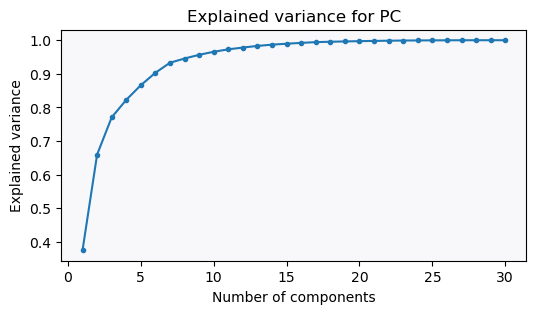

In [7]:
# explained variance plot for PCA

fig, ax = plt.subplots(figsize=(6, 3))

pc = PCA()
pc.fit(scaled_data)
expl_var = pc.explained_variance_ratio_.cumsum()
pd.Series(expl_var, index=range(1, scaled_data.shape[1] + 1)).loc[:50].plot(
    style=".-", title="Explained variance for PC"
)

ax.set_xlabel("Number of components")
ax.set_ylabel("Explained variance")
ax.set_facecolor("#F8F8FB")

# plt.savefig('FigureSI_Variance_PC.svg', format='svg', bbox_inches='tight', dpi=600)

In [8]:
# 5 dimensions account for ~90% of the variance
PC5_df = pd.DataFrame(
    (PCA(n_components=5)).fit_transform(scaled_data),
    index=scaled_data.index,
    columns=[f"PC{i}" for i in range(1, 6)],
)

In [9]:
# Read experimental data and merge DFT features with results

exp_df = pd.read_csv("Experimental_CCS.csv", sep=';', index_col=0, encoding='latin-1')
matching_df = pd.concat([PC5_df, exp_df], axis=1, join="inner")

X, y = (
    matching_df.loc[
        :,
        (matching_df.columns != "Names")
    & (matching_df.columns != "CCS"),
    ],
    matching_df["CCS"],
)
# Check whether there is NaN
nanlist = list(np.where(y.isna())[0])
rowlist = X.index
for i in nanlist:
    print(rowlist[i])
    X = X.drop([rowlist[i]])
    y = y.drop([rowlist[i]])

print(f"Number of features: {X.shape[1]}, number of samples: {X.shape[0]}")

Number of features: 5, number of samples: 27


### Modeling

Random forest is used as regressor

In [10]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_features=None,
    max_leaf_nodes=None,
    min_samples_leaf=1,
    random_state=1
)
rf.fit(X.values, y.values)
y_pred = rf.predict(X.values)

0.9552533983150099 MAE: 1.5685518518518464


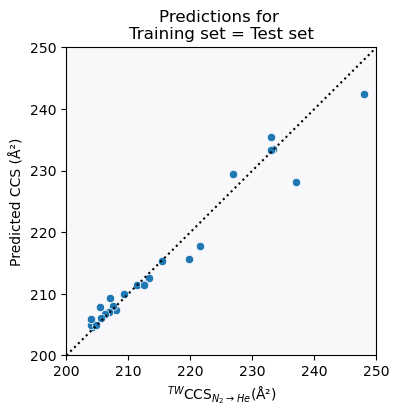

In [11]:
#First, check if the model can predict its own training values

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_ylim(200, 250)
ax.set_xlim(200, 250)

ax.set_xlabel(r"$^{TW}$CCS$_{N_{2}}$$_{\rightarrow}$$_{He}$(Å²)")
ax.set_ylabel("Predicted CCS (Å²)")

sns.scatterplot(x=y.values, y=y_pred).set_title(
    "Predictions for \nTraining set = Test set",
)
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ":k")

ax.set_facecolor("#F8F8FB")

print(r2_score(y.values, y_pred), "MAE:", mean_absolute_error(y.values, y_pred))
#plt.savefig('Figure2_Training_same_Test.svg', format='svg', bbox_inches='tight', dpi=600)

0.6424654979428601 MAE: 4.424425925925908


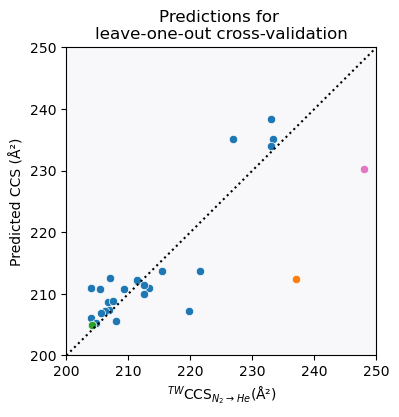

In [12]:
#Graphical representation of the L1O-CV predictions

cv_predict = cross_val_predict(
    rf, X.values, y.values, cv=KFold(n_splits=X.shape[0], shuffle=True)
)

#Getting the worst two predictions, and their index
diff_df = abs(cv_predict - y)
diff_list = [*diff_df.values]
worst_index = [diff_list.index(x) for x in sorted(diff_list, reverse=True)[:2]]

C4_index = y.index.get_loc('NCCCN')

worst1_dict = {'predict' : cv_predict[worst_index[0]], 'data': y.values[worst_index[0]]}
worst2_dict = {'predict' : cv_predict[worst_index[1]], 'data': y.values[worst_index[1]]}
C4_dict = {'predict' : cv_predict[C4_index], 'data': y.values[C4_index]}
worst1_df = pd.DataFrame([worst1_dict])
worst2_df = pd.DataFrame([worst2_dict])
C4_df = pd.DataFrame([C4_dict])

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_ylim(200, 250)
ax.set_xlim(200, 250)

ax.set_xlabel(r"$^{TW}$CCS$_{N_{2}}$$_{\rightarrow}$$_{He}$(Å²)")
ax.set_ylabel("Predicted CCS (Å²)")

sns.scatterplot(x=y.values, y=cv_predict).set_title(
    "Predictions for \nleave-one-out cross-validation"
)
sns.scatterplot(data = worst1_df, x='data', y='predict', c='tab:orange')
sns.scatterplot(data = worst2_df, x='data', y='predict', c='tab:pink')
sns.scatterplot(data = C4_df, x='data', y='predict', c='tab:green')

# ax.errorbar(y.values, row_avg.values, yerr=row_std.values, fmt='.')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ":k")

ax.set_facecolor("#F8F8FB")

print(r2_score(y.values, cv_predict), "MAE:", mean_absolute_error(y.values, cv_predict))
#plt.savefig('Figure2_L1O.svg', format='svg', bbox_inches='tight', dpi=600)

0.645016744121113 MAE: 4.5544884814815285


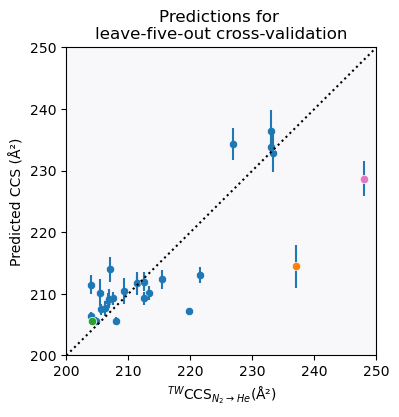

In [13]:
#Graphical representation of the L5O-CV predictions

predictions_cv = pd.DataFrame()
i = 0
while i < 100:
    cv_predict = cross_val_predict(
        rf, X.values, y.values, cv=KFold(n_splits=X.shape[0] // 5, shuffle=True)
    )
    predictions_cv[i] = cv_predict
    i += 1

row_avg = predictions_cv.mean(axis=1)
row_std = predictions_cv.std(axis=1)

#Getting the worst two predictions, and their index
diff_df = abs(row_avg.values - y.values)
diff_list = [*diff_df]
worst_index = [diff_list.index(x) for x in sorted(diff_list, reverse=True)[:2]]

C4_index = y.index.get_loc('NCCCN')

worst1_dict = {'predict' : row_avg[worst_index[0]], 'data': y.values[worst_index[0]]}
worst2_dict = {'predict' : row_avg[worst_index[1]], 'data': y.values[worst_index[1]]}
C4_dict = {'predict' : row_avg[C4_index], 'data': y.values[C4_index]}
worst1_df = pd.DataFrame([worst1_dict])
worst2_df = pd.DataFrame([worst2_dict])
C4_df = pd.DataFrame([C4_dict])

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_ylim(200, 250)
ax.set_xlim(200, 250)

ax.set_xlabel(r"$^{TW}$CCS$_{N_{2}}$$_{\rightarrow}$$_{He}$(Å²)")
ax.set_ylabel("Predicted CCS (Å²)")

sns.scatterplot(x=y.values, y=row_avg.values).set_title(
    "Predictions for \nleave-five-out cross-validation"
)
ax.errorbar(y.values, row_avg.values, yerr=row_std.values, fmt=".", zorder=1)

sns.scatterplot(data = worst1_df, x='data', y='predict', c='tab:orange', zorder=2)
sns.scatterplot(data = worst2_df, x='data', y='predict', c='tab:pink', zorder=2)
sns.scatterplot(data = C4_df, x='data', y='predict', c='tab:green', zorder=2)

x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ":k")

ax.set_facecolor("#F8F8FB")

print(r2_score(y.values, row_avg.values), "MAE:", mean_absolute_error(y.values, row_avg.values))
#plt.savefig('Figure2_L5O.svg', format='svg', bbox_inches='tight', dpi=600)

### Predicting the CCS of compounds from library (Cutoff for diamines with Mw < 225 Da)

In [14]:
#First, we regenerate the clusters observed with UMAP reduction in the notebook '2_clustering'

CLS = 6  # fix the number of clusters for further cells (change this as desired)
nneigh = int(np.sqrt(scaled_data.shape[1]))
dfs = {}
dfs["umap10"] = pd.DataFrame(
        UMAP(
            n_components=10, n_neighbors=nneigh, random_state=np.random.RandomState(420)
        ).fit_transform(scaled_data),
        index=scaled_data.index,
        columns=[f"UMAP{i}" for i in range(1, 11)],
    )

Z = {}
# compute linkages - this is the Agglomerative Hierarchical Clustering
Z["umap10"] = linkage(dfs["umap10"], method="ward")

# chop the dendrograms at a given height and get the cluster assignments
cls_UMAP = {}
cls_UMAP["umap10"] = fcluster(Z["umap10"], CLS, criterion="maxclust")

cls_UMAP_df = pd.DataFrame(cls_UMAP)
weighted_data["cls_UMAP"] = cls_UMAP_df["umap10"].values

C:\Users\qduez\miniconda3\envs\autoqchem\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [15]:
filter_df = weighted_data[
    weighted_data.molar_mass < 225
]  # Just with guests with Mw < 225 to avoid extrapolating too much
PC5_merged = pd.concat([PC5_df, filter_df], axis=1, join="inner")
PC5_merged = PC5_merged[["PC1", "PC2", "PC3", "PC4", "PC5"]]

mass_df = pd.concat([weighted_data, exp_df], axis=1, join="inner")

CCS_pred = rf.predict(PC5_merged)
print(CCS_pred.shape)

CCS_pred_df = pd.DataFrame()
CCS_pred_df["mass"] = filter_df["molar_mass"]
CCS_pred_df["CCS_pred"] = CCS_pred
CCS_pred_df["Clusters UMAP"] = weighted_data["cls_UMAP"]

(75,)


C:\Users\qduez\miniconda3\envs\autoqchem\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Text(0, 0.5, 'Silhouette index')

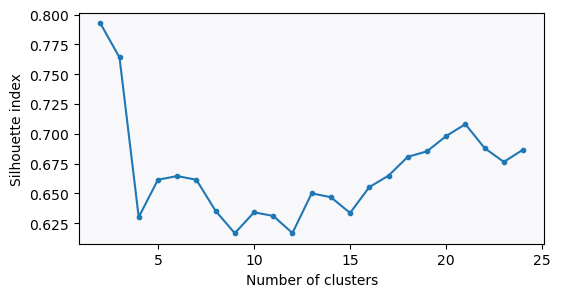

In [16]:
# Hierarchical clustering of the predicted datapoints

# NCLS = 2 # fix the number of clusters for further cells (change this as desired)

silhouette_df = pd.DataFrame(columns=["N_clust", "silhouette_score"])

for NCLS in range(2, 25):

    Z = {}
    # compute linkages - this is the Agglomerative Hierarchical Clustering
    Z["all"] = linkage(CCS_pred_df[["CCS_pred"]], method="ward")

    # chop the dendrograms at a given height and get the cluster assignments
    cls = {}
    cls["all"] = fcluster(Z["all"], NCLS, criterion="maxclust")

    silhouette = silhouette_score(CCS_pred_df[["CCS_pred"]], cls["all"])
    temp_dict = {"N_clust": [NCLS], "silhouette_score": [silhouette]}
    temp_df = pd.DataFrame(data=temp_dict)
    silhouette_df = pd.concat([silhouette_df, temp_df])

fig, ax = plt.subplots(figsize=(6, 3))

sns.scatterplot(data=silhouette_df, x="N_clust", y="silhouette_score", s=20)
sns.lineplot(data=silhouette_df, x="N_clust", y="silhouette_score")
ax.set_facecolor("#F8F8FB")

ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette index")

#plt.savefig('FigureSI_Silhouette_PredictedCCS.svg', format='svg', bbox_inches='tight', dpi=600)
# cls_df=pd.DataFrame(cls)

In [17]:
# Hierarchical clustering of the predicted datapoints

NCLS = 2  # fix the number of clusters 

Z = {}
# compute linkages - this is the Agglomerative Hierarchical Clustering
Z["all"] = linkage(CCS_pred_df[["CCS_pred"]], method="ward")

# chop the dendrograms at a given height and get the cluster assignments
cls = {}
cls["all"] = fcluster(Z["all"], NCLS, criterion="maxclust")

In [18]:
# Now use these pseudo-labels to train a classifier based on the clustered data
clf = LogisticRegression()
clf.fit(CCS_pred_df[["mass", "CCS_pred"]], cls["all"])

LogisticRegression()

In [19]:
# Create a mesh grid to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(0, 230, 2000), np.linspace(200, 250, 2000))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

C:\Users\qduez\miniconda3\envs\autoqchem\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Text(0.5, 0, 'Guest mass (amu)')

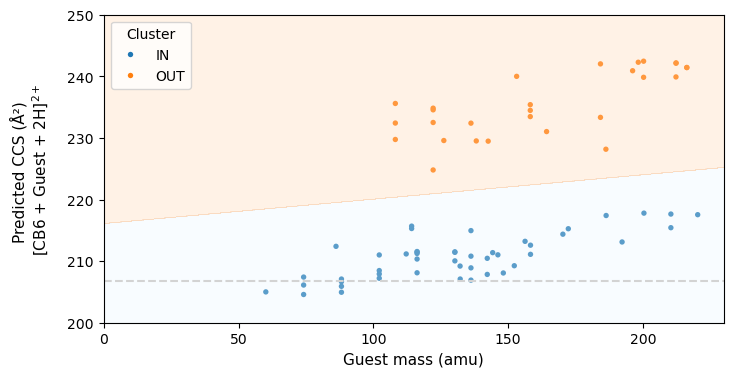

In [20]:
CCS_pred_df["Cls"] = cls["all"]

CCS_pred_df["Cluster"] = np.where(CCS_pred_df['Cls'] == 1, 'IN', 'OUT')

# Plot the decision boundary and the data points
cmap_light = ListedColormap(["#e8f6ff", "#ffd4af"])

fig, ax = plt.subplots(figsize=(8, 4))
sns.scatterplot(
    data=CCS_pred_df,
    x="mass",
    y="CCS_pred",
    hue="Cluster",
    palette="tab10",
    alpha=1,
    s=15,
    linewidth=0,
)
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

ax.axhline(206.8, linestyle='--', c='lightgrey', alpha=1)

# sns.scatterplot(data=filter_df, x='molar_mass', y=CCS_pred, c='black', alpha=0.7, s=15, linewidth=0)
#sns.scatterplot(data=mass_df, x='molar_mass', y=y.values, alpha=1, s=15, linewidth=0, c='red')
ax.set_xlim(0, 230)
ax.set_ylim(200, 250)
ax.set_ylabel(
    "Predicted CCS (Å²) \n[CB6 + Guest + 2H]$^{2+}$", fontsize=11, wrap=True, labelpad=12
)
ax.set_xlabel("Guest mass (amu)", fontsize=11, wrap=True)
#plt.savefig('Figure2_Predicted_CCS_mass_overlayexp.svg', format='svg', bbox_inches='tight', dpi=600)

Text(0.5, 0, 'Guest mass (amu)')

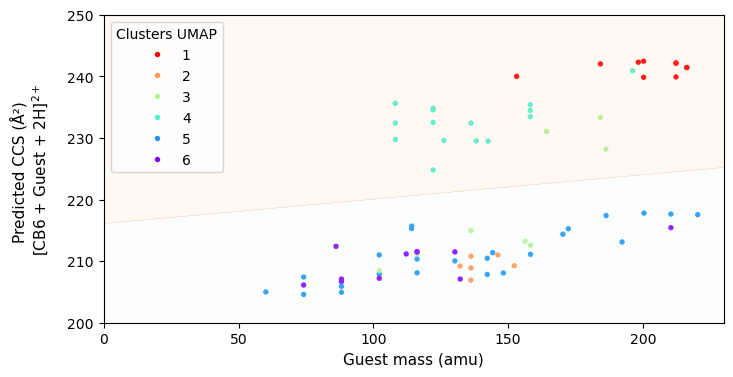

In [21]:
#Let's see how the UMAP clusters are spread on the CCS/Mass space

# Plot the decision boundary and the data points
cmap_light = ListedColormap(["#e8f6ff", "#ffd4af"])

fig, ax = plt.subplots(figsize=(8, 4))
sns.scatterplot(
    data=CCS_pred_df,
    x="mass",
    y="CCS_pred",
    hue="Clusters UMAP",
    palette="rainbow_r",
    alpha=1,
    s=15,
    linewidth=0,
)
plt.contourf(xx, yy, Z, alpha=0.15, cmap=cmap_light)

#x.axhline(206.8, linestyle='--', c='lightgrey', alpha=1)

# sns.scatterplot(data=filter_df, x='molar_mass', y=CCS_pred, c='black', alpha=0.7, s=15, linewidth=0)
#sns.scatterplot(data=mass_df, x='molar_mass', y=y.values, alpha=1, s=15, linewidth=0, c='red')
ax.set_xlim(0, 230)
ax.set_ylim(200, 250)
ax.set_ylabel(
    "Predicted CCS (Å²) \n[CB6 + Guest + 2H]$^{2+}$", fontsize=11, wrap=True, labelpad=12
)
ax.set_xlabel("Guest mass (amu)", fontsize=11, wrap=True)
#plt.savefig('FigureSI_CCS_mass_Cls_UMAP_distribution.svg', format='svg', bbox_inches='tight', dpi=600)

In [22]:
print(CCS_pred_df)

                                    mass  CCS_pred  Clusters UMAP  Cls Cluster
can                                                                           
NCCCCCCCCCCCCN                  200.3666  217.7913              5    1      IN
NC1C(N)CCCC1                    114.1900  215.6805              5    1      IN
NCCCN                            74.1254  204.5827              5    1      IN
CC(N)CN                          74.1254  207.4107              5    1      IN
NC1=CC=CC=C1N                   108.1426  229.7487              4    2     OUT
...                                  ...       ...            ...  ...     ...
OC1=CC(N)=CC=C1OC2=CC=C(N)C=C2  216.2390  241.4304              1    2     OUT
CC1=C(N)C=CC=C1N                122.1694  234.5602              4    2     OUT
N[C@@H](CCCCN)C(O)=O            146.1888  211.0211              2    1      IN
NC1CC(CN)(CC(C)(C1)C)C          170.2972  214.3722              5    1      IN
NC1=CC=CC=C1NC2=CC=CC=C2        184.2402  233.3365  

In [23]:
SMILES_exp = exp_df.index.values
CCS_exp = exp_df["CCS"].values

test_merged = PC5_df.loc[SMILES_exp]

#Prepare a dataframe for the test set
pred_df = pd.DataFrame()
pred_df["mass"] = weighted_data["molar_mass"].loc[SMILES_exp]
pred_df["CCS_pred"] = rf.predict(test_merged)
clf_pred = clf.predict(pred_df[["mass", "CCS_pred"]])

C:\Users\qduez\miniconda3\envs\autoqchem\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


,mass,CCS_pred,Clusters UMAP,Cls,Cluster,Molecule
can,,,,,,
NCCN,60.10,205.00,5,1,IN,
CNCCN,74.13,206.12,6,1,IN,
NCCCN,74.13,204.58,5,1,IN,
CC(N)CN,74.13,207.41,5,1,IN,
N1CCNCC1,86.14,212.40,6,1,IN,
NCCCCN,88.15,204.95,5,1,IN,
CCNCCN,88.15,206.67,6,1,IN,
NCCCNC,88.15,205.91,5,1,IN,
CNCCNC,88.15,207.09,6,1,IN,

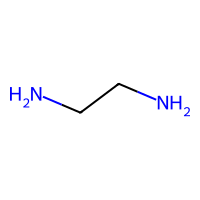
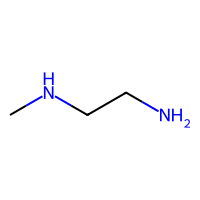
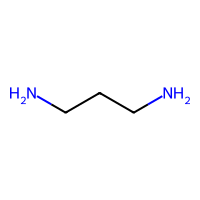
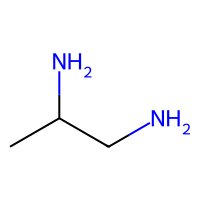
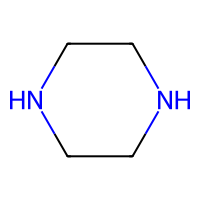
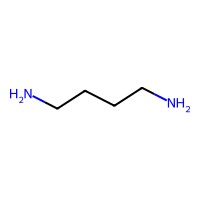
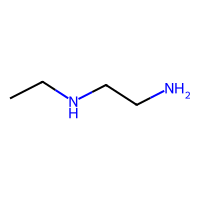
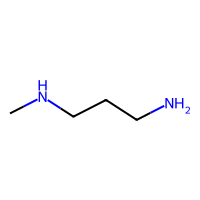
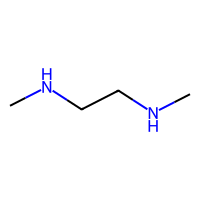
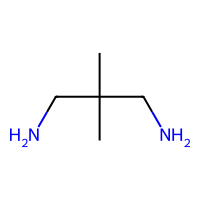
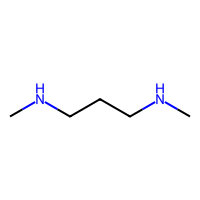
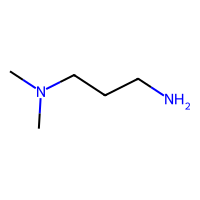
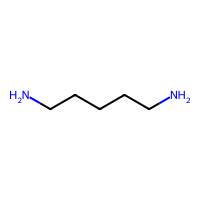
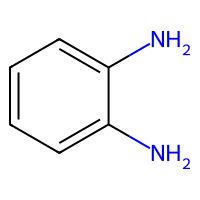
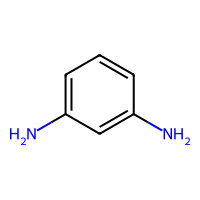
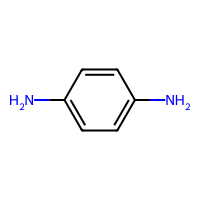
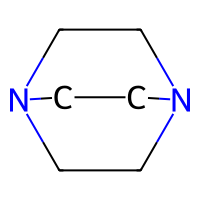
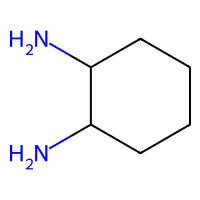
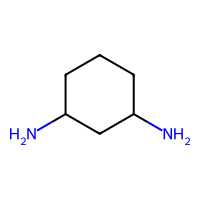
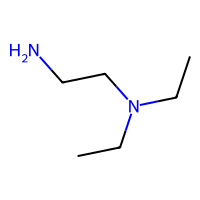
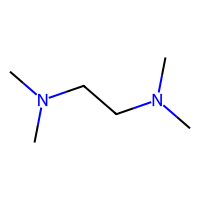
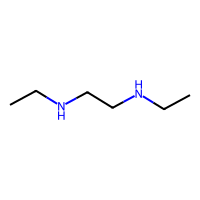
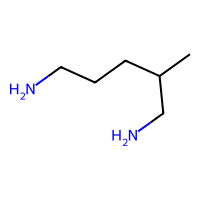
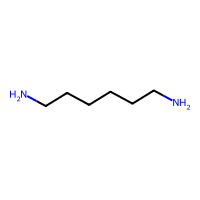
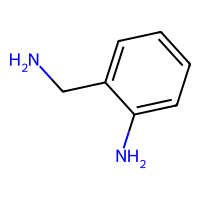
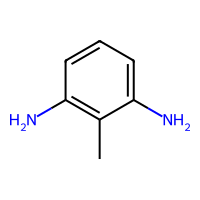
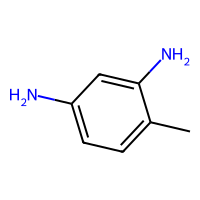
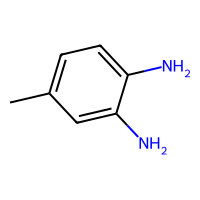
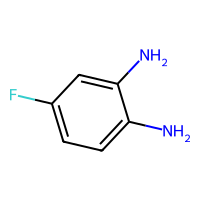
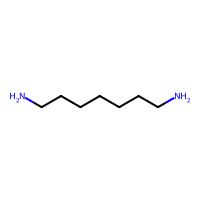
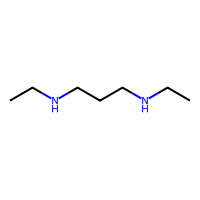
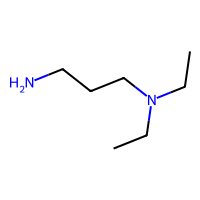
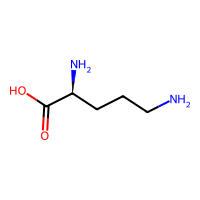
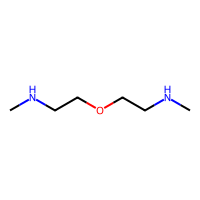
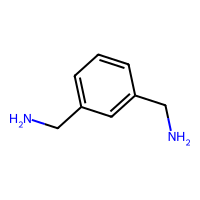
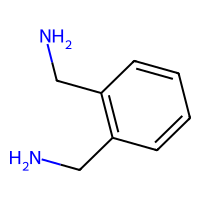
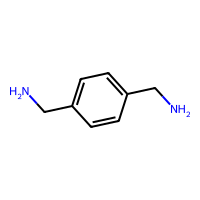
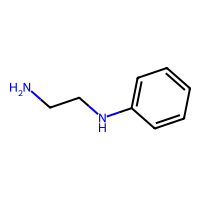
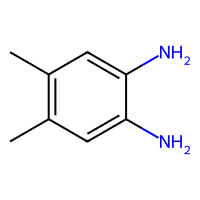
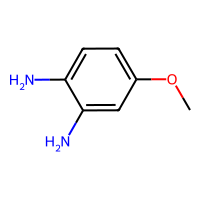
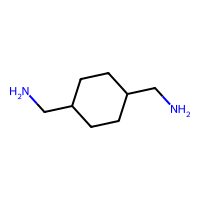
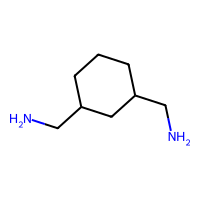
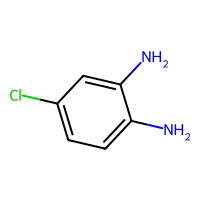
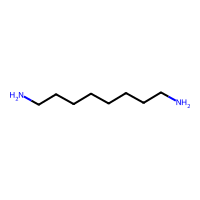
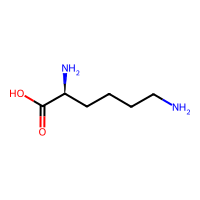
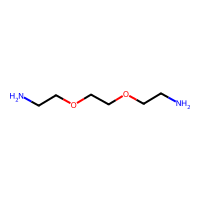
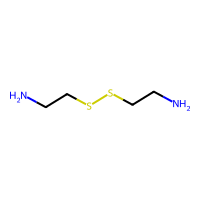
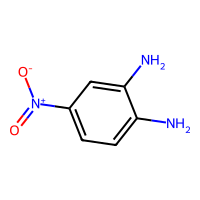
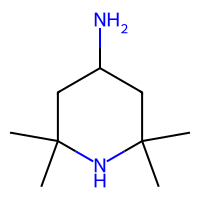
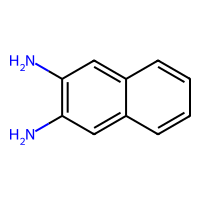
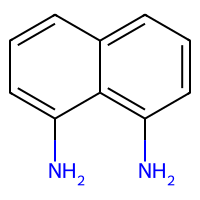
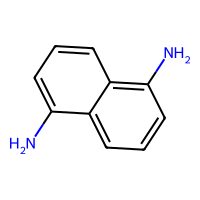
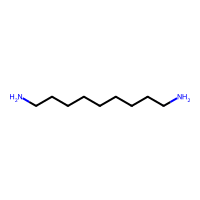
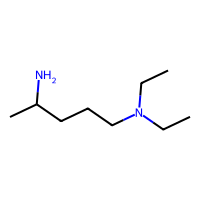
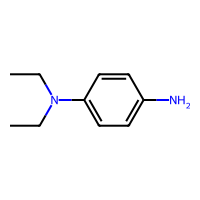
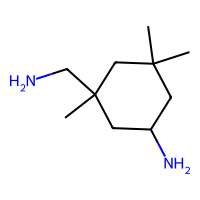
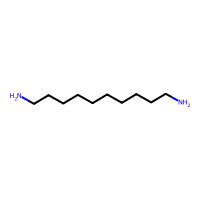
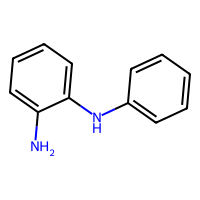
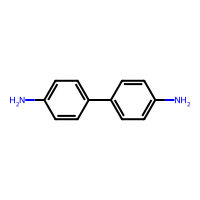
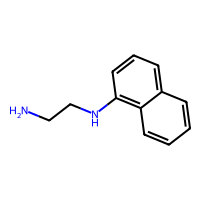
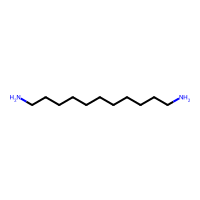
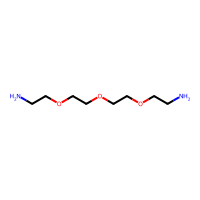
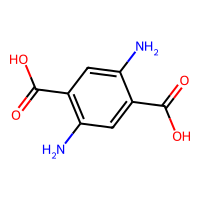
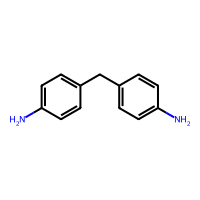
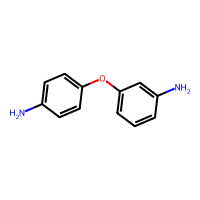
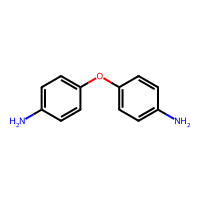
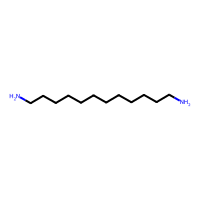
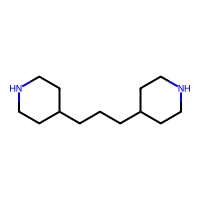
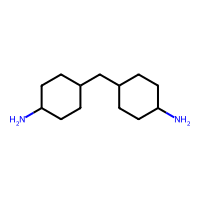
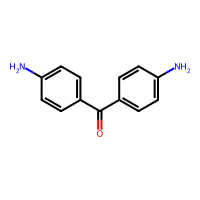
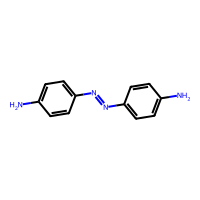
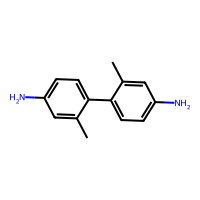
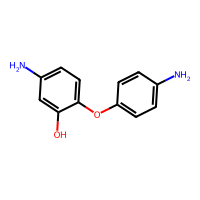
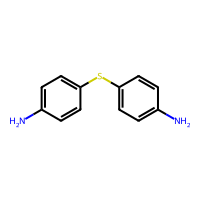
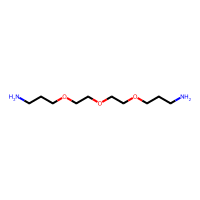

In [24]:
#Getting a table with the predicted results and corresponding structures
#Table S2

from pandas.plotting import table
from rdkit import Chem
from rdkit.Chem import PandasTools
from IPython.display import display, Image
from IPython.core.display import HTML

import imgkit


CCS_table = CCS_pred_df.reset_index()
CCS_table = CCS_table.round(2)
CCS_table = CCS_table.sort_values(by=['mass'])

#CCS_table = CCS_table[10:20]

PandasTools.AddMoleculeColumnToFrame(CCS_table, 'can', 'Molecule')

CCS_table.set_index('can', inplace=True)
# Uncomment to convert HTML table to an image
#html_str = CCS_table.to_html()
#imgkit.from_string(html_str, "table2.png")  

display(HTML(CCS_table.to_html()))




### Classifying compounds unseen by the model

In [25]:
SMILES_test = [
    "NC1=CC=CC=C1N",
    "NCC1=CC=CC=C1N",
    "NCC1=CC=C(CN)C=C1",
    "NCCNC1=CC=CC=C1",
]  # O-phenyl diamine, 2-Aminobenzylamine, PXD, N-Phenyl ethylene diamine

test_merged = PC5_df.loc[SMILES_test]
test_pred = rf.predict(test_merged)

print(test_pred)

[229.7487 224.7967 208.9059 214.9522]


C:\Users\qduez\miniconda3\envs\autoqchem\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [26]:
pred_df = pd.DataFrame()
pred_df["mass"] = [108, 122, 136, 136]
pred_df["CCS_pred"] = test_pred
clf_pred = clf.predict(pred_df[["mass", "CCS_pred"]])
print(clf_pred)

[2 2 1 1]
